In [4]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Classifiying lifestyle segments

Logisitive regression (& less accurate decision tree) model that learns how to assign customers to their appropriate cluster.

Model is then converted to SQL text and output for use in-database, hence the use of simple models as classifiers

### Import data

Connect to DB and import, or load .csv

In [5]:
# First, get a list of the actual features used by the real-life segmentation model
features_used_df = pd.read_csv('features_used_ICIBE.csv', header=None, names=['feature'], encoding='ISO-8859-1')
features_used_df['feature'] = features_used_df['feature'].str.lower()
feature_list = features_used_df['feature'].tolist()
feature_list.append('cluster5')

In [6]:
# Load main data usedby real-life segmentation model either from db or a csv
from_db = 0

if from_db:
    conn = cx_Oracle.connect('achan', 'GCRM@asw1', 'uksbldb11-vip.uk.aswatson.net:1521/CRMBKVP_PRIMARY')  # CRMBKVP
    cur = conn.cursor()

    cur.execute('SELECT * FROM ICIBE_SEG_BASE_FINAL')
    res = cur.fetchall()
    df = pd.DataFrame(res)
    df.columns = [desc[0] for desc in cur.description]
    df.columns = [x.lower() for x in df.columns]
    
    df.to_csv('custering_data.csv', index=False)
else:
    df = pd.read_csv('custering_data.csv')
    
df = df[feature_list]
df.head()

trxs_l12m  sales_l12m  items_l12m  ppa_ll12m    atv_l12m  ipt_l12m  \
0         14     1015.00          25  40.600000   72.500000  1.785714   
1          3      157.40           5  31.480000   52.466667  1.666667   
2          3      365.85           6  60.975000  121.950000  2.000000   
3          5      762.16          14  54.440000  152.432000  2.800000   
4          9      688.28          12  57.356667   76.475556  1.333333   

   week_day_trxs_share_l12m  week_end_trxs_share_l12m  \
0                  0.714286                  0.285714   
1                  0.666667                  0.333333   
2                  0.333333                  0.666667   
3                  0.600000                  0.400000   
4                  1.000000                  0.000000   

   work_hours_trxs_share_l12m  new_3months_trxs_share_l12m    ...     \
0                    0.642857                     0.142857    ...      
1                    0.666667                     0.000000    ...      
2                    0.333333                     0.000000    ...      
3                    0.400000                     0.000000    ...      
4                    1.000000                     0.000000    ...      

   top_prod_16_ar_trxs_share  top_prod_17_ar_trxs_share  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   top_prod_18_ar_trxs_share  top_prod_19_ar_trxs_share  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   top_prod_20_ar_trxs_share  top_prod_21_ar_trxs_share  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   top_prod_22_ar_trxs_share  top_prod_23_ar_trxs_share  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   top_prod_24_ar_trxs_share  cluster5  
0                        0.0         1  
1                        0.0         2  
2                        0.0         3  
3                        0.0         1  
4                        0.0         2  

[5 rows x 40 columns]

### Preprocessing

##### Check for nulls

In [7]:
for feat in df.columns:
    n_nulls = sum(df[feat].isnull())
    if n_nulls > 0:
        print('Feature {} is {:.2f}% null'.format(feat, 100*n_nulls/len(df)))

Deal with a couple of specific cases

##### Encode categorical variables

In [8]:
categoricals = df.columns[df.dtypes == 'object']
for feat in categoricals:
    print('One hot encoding categorical feature {}'.format(feat))
    encoder = LabelBinarizer()
    col_names = ['{}_{}'.format(feat, i) for i in range(len(df[feat].unique()))]
    temp_df = pd.DataFrame(encoder.fit_transform(df[feat]), columns=col_names)
    df = pd.concat([df, temp_df], axis=1)
    df.drop(feat, axis=1, inplace=True)

### Split into train test

In [9]:
# Separate target variable and contact key metadata
y = df.pop('cluster5')
# contact_key = df.pop('contact_key')

In [10]:
# Split, stratifying by cluster
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.2, random_state=0, stratify=y)

### Train the tree

In [11]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=50,
                              class_weight=None)  # {1: 0.24, 2: .18, 3: .18, 4: .18, 5: .22})
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Train a logistic regression

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Check accuracy

In [13]:
y_pred_tree = tree.predict(X_test)
y_pred_log = logreg.predict(X_test)

In [14]:
tree_accuracy = accuracy_score(y_pred=y_pred_tree, y_true=y_test)
print('Tree accuracy = {:.2f}%'.format(100*tree_accuracy))
log_accuracy = accuracy_score(y_pred=y_pred_log, y_true=y_test)
print('Log accuracy = {:.2f}%'.format(100*log_accuracy))

Tree accuracy = 81.61%
Log accuracy = 95.71%


In [15]:
for class_ in np.unique(y_test):
    class_mask = y_test == class_ 
    print('cluster {}: tree accuracy = {:.2f}%, log_accuracy = {:.2f}%'\
          .format(class_, 
                  100*accuracy_score(y_test[class_mask], y_pred_tree[class_mask]),
                  100*accuracy_score(y_test[class_mask], y_pred_log[class_mask])))

cluster 1: tree accuracy = 55.43%, log_accuracy = 95.75%
cluster 2: tree accuracy = 92.00%, log_accuracy = 95.61%
cluster 3: tree accuracy = 93.78%, log_accuracy = 96.85%
cluster 4: tree accuracy = 91.68%, log_accuracy = 98.78%
cluster 5: tree accuracy = 51.67%, log_accuracy = 94.61%
cluster 6: tree accuracy = 78.50%, log_accuracy = 89.30%


### Logistic Regression is better, use that

In [16]:
print(classification_report(y_test, y_pred_log, target_names=['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']))

             precision    recall  f1-score   support

   cluster1       0.95      0.96      0.95     54095
   cluster2       0.97      0.96      0.96    115850
   cluster3       0.95      0.97      0.96     73378
   cluster4       0.93      0.99      0.96     32538
   cluster5       0.96      0.95      0.95     31406

avg / total       0.96      0.96      0.96    329049



C:\Users\shephej\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 5
  .format(len(labels), len(target_names))


In [17]:
y_test_hist, x_hist = np.histogram(y_test, bins=[1, 2, 3, 4, 5, 6])
y_pred_hist, _ = np.histogram(y_pred_log, bins=[1, 2, 3, 4, 5, 6])
y_pred_hist_tree, _ = np.histogram(y_pred_tree, bins=[1, 2, 3, 4, 5, 6])

In [18]:
y.value_counts()

2    579249
3    366889
1    270473
4    162691
5    157031
6    108909
Name: cluster5, dtype: int64

C:\Users\shephej\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


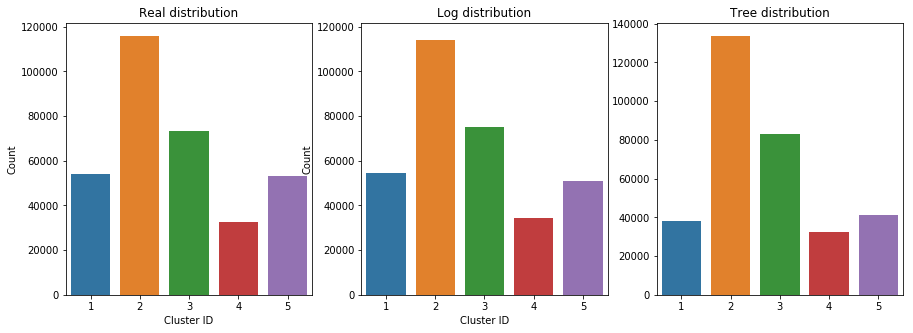

In [19]:
fig, (ax, ax1, ax2) = plt.subplots(1,3,figsize=[15,5])
sns.barplot(x_hist[:-1], y_test_hist, label='True', ax=ax)
sns.barplot(x_hist[:-1], y_pred_hist, label='Predicted', ax=ax1)
sns.barplot(x_hist[:-1], y_pred_hist_tree, label='Predicted', ax=ax2)
ax.set_title('Real distribution')
ax1.set_title('Log distribution')
ax2.set_title('Tree distribution')
for axes in (ax, ax1):
    axes.set_xlabel('Cluster ID')
    axes.set_ylabel('Count')
    axes.set_ylim([0, max(max(y_test_hist), max(y_pred_hist)) + 0.05*max(max(y_test_hist), max(y_pred_hist))])
plt.show()

### Visualise the tree

In [20]:
export_graphviz(decision_tree=tree, 
                feature_names=X_train.columns,
                filled=True,
                proportion=True,
                rounded=True,
                rotate=True,
                out_file='tree.dot')

### Extract Logistic equation as SQL

In [21]:
def softmax(X):
    y = np.exp(X) / np.sum(np.exp(X), axis=0)
    return y

In [22]:
# Check my understanding of the coefficients matches the predict function
results = []
for i in range(999):
    X = np.dot(X_train.iloc[i, :], logreg.coef_.T) + logreg.intercept_
    p = np.argmax(softmax(X)) + 1
    p2 = logreg.predict(X_train.iloc[i, :].reshape(1, -1))
    results.append(p==p2)
    #print('{}'.format(p2))
results = np.array(results)

C:\Users\shephej\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [23]:
sum(results) / len(results)

array([ 1.])

In [24]:
sql_statements = []
sql_string = 'SELECT \n\nseg.*,\n'
for i_class in range(len(logreg.coef_)):
    
    class_coeffs = logreg.coef_[i_class]
    feats = X_train.columns
    for i_feat in range(len(feats)):
        if i_feat == 0:
            sql_string = sql_string + '{} * {}'.format(class_coeffs[i_feat], feats[i_feat])
        else:
            sql_string = sql_string + ' + {} * {}'.format(class_coeffs[i_feat], feats[i_feat])
    sql_string += ' + {}'.format(logreg.intercept_[i_class]) + \
                  ' AS linear_comp_{},\n'.format(i_class+1)
sql_string = sql_string[:-2]
sql_string += '\n\nFROM ICINL_SEG_BASE_FINAL seg'

In [25]:
second_query = 'SELECT \n\nint.*,\n'
for i_class in range(len(logreg.coef_)):
    second_query += 'EXP(linear_comp_{})'.format(i_class+1)
    second_query += ' AS probability_class_{},\n'.format(i_class+1)
second_query += 'CASE\n'
for i_class_2 in range(len(logreg.coef_)):
    second_query += 'WHEN GREATEST(\n'
    for i_class in range(len(logreg.coef_)):
        second_query
        second_query += 'EXP(linear_comp_{})'\
                        .format(i_class+1)
        second_query += ',\n'
    second_query = second_query[:-2] + '\n) = ' + \
    'EXP(linear_comp_{}) THEN {}\n'\
    .format(i_class_2+1, i_class_2+1)
    
second_query += 'END AS predicted_cluster'
second_query += '\n\nFROM ( \n\n' + sql_string + '\n ) int'
print(second_query)

SELECT 

int.*,
EXP(linear_comp_1) AS probability_class_1,
EXP(linear_comp_2) AS probability_class_2,
EXP(linear_comp_3) AS probability_class_3,
EXP(linear_comp_4) AS probability_class_4,
EXP(linear_comp_5) AS probability_class_5,
EXP(linear_comp_6) AS probability_class_6,
CASE
WHEN GREATEST(
EXP(linear_comp_1),
EXP(linear_comp_2),
EXP(linear_comp_3),
EXP(linear_comp_4),
EXP(linear_comp_5),
EXP(linear_comp_6)
) = EXP(linear_comp_1) THEN 1
WHEN GREATEST(
EXP(linear_comp_1),
EXP(linear_comp_2),
EXP(linear_comp_3),
EXP(linear_comp_4),
EXP(linear_comp_5),
EXP(linear_comp_6)
) = EXP(linear_comp_2) THEN 2
WHEN GREATEST(
EXP(linear_comp_1),
EXP(linear_comp_2),
EXP(linear_comp_3),
EXP(linear_comp_4),
EXP(linear_comp_5),
EXP(linear_comp_6)
) = EXP(linear_comp_3) THEN 3
WHEN GREATEST(
EXP(linear_comp_1),
EXP(linear_comp_2),
EXP(linear_comp_3),
EXP(linear_comp_4),
EXP(linear_comp_5),
EXP(linear_comp_6)
) = EXP(linear_comp_4) THEN 4
WHEN GREATEST(
EXP(linear_comp_1),
EXP(linear_comp_2),
EXP(linear